In [855]:
!pip install numpy micrograd matplotlib


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class Value:
    def __init__(self, x, _children=set(), _op='', label=''):
        self.data = x
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    def __radd__(self, other): 
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad = +other.data * out.grad
            other.grad = +self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other
    def __neg__(self): 
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        out = Value(self.data ** other, (self,), label=f'**{other}')
        def _backward():
            # Corrected line for gradient calculation
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out
    
    def __repr__(self):
        return f"Value=(data={self.data})"

    def exp(self): 
        x = self.data 
        out = Value(math.exp(x), (self, ), label='exp')
        def _backward():
            self.grad = out.data * out.grad
        self._backward = _backward

        return out

    def __truediv__(self, other):
        return self * (other ** -1)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        self.grad = 1
        for v in reversed(topo):
            v._backward()
   
        
        

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
import matplotlib.image as mpimg
img=mpimg.imread('neuronMathModel.png')
plt.imshow(img)

In [ ]:
# Inputs to a neuron are called axons and mathematically they can be x0, x1... xn. Inputs come to a neuron through synapses. 
# Each synapse has a weight associated with it. When an input x0 comes to neuron through a synapse s with weight w0, the weight of synapse w0 gets multiplied to x0. 

# If a neuron has n synapses and n inputes are sent through those n synapses, overall input to a neuron becomes:
# x0w0 + x1w1 + .... + xnwn
# Bias
# Bias of a neuron is the 'happy trigger' that is applies to the output
# So the neuron will be applying bias be to the afformentioned input. (x0w0 + x1w1 + ... + nxwn) + b
# Apply the activation function to the output of n to get the final output of the neuron




In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
o.backward()

In [ ]:
draw_dot(o)

In [ ]:
import random
class Neuron: 
    def __init__(self, n):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # x * w + b 
        act = sum(wi * xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh() 
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self. neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs
    def parameters(self): 
        params = []
        params.extend(neuron.parameters() for neuron in self.neurons)
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x[0] if len(x) == 1 else x

    def parameters(self):
        return [param for layer in self.layers for neuron in layer.neurons for param in neuron.parameters()]
        
        

In [ ]:
"""
Let's try and figure out why a single neuron is not apt for non-linear data. 

The output of a neuron with inputs x1, x2 and weights w1, w2 and bias b is defined as,
    y = x1w1 + x2w2 + b

    The above equation defines a line in 2D plane.
    Hence each neuron slices the input space by a line, also known as its decision boundary. 

    Any point on one side of that line, the nueron classifies as activated or 1 and any point below it, the neuron classifies as 0 or weak.


What is a decision boundary?
A decision boundary of a neuron is a line above which the output of that neuron is >0 or 'activated' and below is < 0 or 'deactivated'.
How do we compute the decision boundary?
Let's take an example of x1 and x2 as inputs, w1 and w2 as weights and b as bias. 

The neuron's output is y. 
y is defined as,

    y = x1w1 + x2w2 +b
    This represents a line in 2D plane. 

On the decision boundary, the output of the neuron is 0. 
Hence, 
    x1w1 + x2w2 + b = 0 

Rearranging terms, 
    x2 = -(w1/w2)x1 - (b / w2) 

    This represents a line with -(w1/w2) as its slope and - (b / w2) as its intercept (this point at which this line intersects x2 axis).
"""

"""
Let's take an example of xor. The xor data is non-linearly scattered. 
Let's see how a single neuron fails to classify a non-linearly scattered data.
"""

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the Neuron and Value classes are defined as in the code provided above

# Define XOR points and labels
xor_points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
labels = np.array([0, 1, 1, 0])

# Create a single neuron with 2 inputs
nn = Neuron(2)


In [ ]:

def plot_decision_boundary(weights, biases):
    # Retrieve weights and bias from the neuron
    # w1 = nn.w[0].data  # Weight for x1
    # w2 = nn.w[1].data  # Weight for x2
    # b = nn.b.data      # Bias

    all_x_vals = []
    all_y_vals = []

    for w, b in zip(weights, biases):
        x_vals = np.linspace(-0.5, 1.5, 100)
        if w[1] != 0:
            y_vals = - (w[0] / w[1]) * x_vals - (b / w[1])
        else:
            y_vals = np.full_like(x_vals, 10)

        all_x_vals.append(x_vals)
        all_y_vals.append(y_vals)

    # Calculate the decision boundary line based on neuron weights and bias
    x_vals = np.linspace(-0.5, 1.5, 100)
    if w2 != 0:
        y_vals = - (w1 / w2) * x_vals - (b / w2)
    else:
        # If w2 is zero, avoid division by zero and set y_vals to an arbitrary large value
        y_vals = np.full_like(x_vals, 10)
    
    # Plot XOR points
    plt.figure(figsize=(8, 6))
    plt.scatter(xor_points[labels == 0][:, 0], xor_points[labels == 0][:, 1], color='red', label='Class 0', s=100, edgecolor='k')
    plt.scatter(xor_points[labels == 1][:, 0], xor_points[labels == 1][:, 1], color='blue', label='Class 1', s=100, edgecolor='k')
    
    # Plot the decision boundary line
    for x, y in zip(all_x_vals, all_y_vals):
         plt.plot(x, y, 'k--', label="")
    
    # Set plot limits and labels
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.title("Decision Boundary Line Created by Single Neuron for XOR Data")
    plt.xlabel("Input x1")
    plt.ylabel("Input x2")
    plt.legend()
    plt.show()

In [ ]:
# Caputre original weights and bias of the neuron. So that when we update weights, we don't actually change the original neuron weights and biases
weights = [[w.data for w in nn.w]]
biases = [nn.b.data]

plot_decision_boundary(weights, biases)

In [ ]:
"""
The boundary line above is created by randomly assigning weights and biases.
"""

In [ ]:
#Obtain ys from neuron

y = [] 

for p in xor_points:
    y.append(nn(p))
    
y3 = y[3]
print(y3)

In [ ]:

# Do backprop to figure out how do weights and bias impact the output.
y3.backward()

In [ ]:
print(f"grad of neuron of w1: {nn.w[0].grad}")
print(f"grad of neuron of w2: {nn.w[1].grad}")
print(f"grad of neuron of bias: {nn.b.grad}")

In [ ]:
"""
From the original decision boundary, we can see that point(1,1) lies on the positive or 'activated' side of the output, but the actual output for point (1,1) should be 0 (1 xor 1 = 0). 
Let's change the weights and bias gradually to accomodate output of y3, which should be close to 0. 
Take a small h and start applying it to weights and biases.
"""

In [ ]:

weights = [[w.data for w in nn.w]]
biases = [nn.b.data]
h = 0.03
w1, w2 = weights[0]
b = biases[0]
for _ in range(10):
    w1 -= h
    w2 -= h
    b -= h
    
    weights.append([w1, w2])
    biases.append(b)

In [ ]:
# Let's plot how the decision boundary moves

plot_decision_boundary(weights, biases)

In [ ]:
# Let's plot just the last boundary line
plot_decision_boundary(weights[len(weights) - 1:], biases[len(biases)-1:])

In [ ]:
"""
As we can see, the last decision boundary after adjusting the weights, correctly classifies the point (1,1).
But it still misclassifies (1, 0). Which is why, single neuron cannot correctly classify non-linear data.
"""

In [ ]:
""" 
Let's start defining multiple neurons, called a layer and see how using multiple neurons, 
the data space is sliced into more complex regions.
"""


In [ ]:
def plot_decision_boundary_layer(weights, biases, colors):
    # Retrieve weights and bias from the neuron
    # w1 = nn.w[0].data  # Weight for x1
    # w2 = nn.w[1].data  # Weight for x2
    # b = nn.b.data      # Bias

    all_x_vals = []
    all_y_vals = []

    for w, b in zip(weights, biases):
        x_vals = np.linspace(-0.5, 1.5, 100)
        if w[1] != 0:
            y_vals = - (w[0] / w[1]) * x_vals - (b / w[1])
        else:
            y_vals = np.full_like(x_vals, 10)

        all_x_vals.append(x_vals)
        all_y_vals.append(y_vals)

    # Calculate the decision boundary line based on neuron weights and bias
    x_vals = np.linspace(-0.5, 1.5, 100)
    if w2 != 0:
        y_vals = - (w1 / w2) * x_vals - (b / w2)
    else:
        # If w2 is zero, avoid division by zero and set y_vals to an arbitrary large value
        y_vals = np.full_like(x_vals, 10)
    
    # Plot XOR points
    plt.figure(figsize=(8, 6))
    plt.scatter(xor_points[labels == 0][:, 0], xor_points[labels == 0][:, 1], color='red', label='Class 0', s=100, edgecolor='k')
    plt.scatter(xor_points[labels == 1][:, 0], xor_points[labels == 1][:, 1], color='blue', label='Class 1', s=100, edgecolor='k')
    
    # Plot the decision boundary line
    for x, y, c in zip(all_x_vals, all_y_vals, colors):
         plt.plot(x, y, f"{c}--", label="")
    
    # Set plot limits and labels
    plt.xlim(-0.5, 1.5)
    plt.ylim(-0.5, 1.5)
    plt.title("Decision Boundary Line Created by Single Neuron for XOR Data")
    plt.xlabel("Input x1")
    plt.ylabel("Input x2")
    plt.legend()
    plt.show()

In [ ]:
layer = Layer(2, 10)

In [ ]:
weights = [[n.w[0].data, n.w[1].data] for n in layer.neurons]
biases = [n.b.data for n in layer.neurons]

colors = ['r', 'g']
plot_decision_boundary_layer(weights, biases, colors)

In [ ]:
# Define xor_inputs here
xor_inputs = [[0,0], [0,1], [1,0], [1,1]]

#This is the expected outputs for all the inputs above
y_exp = [0, 1, 1, 0]

In [ ]:
"""
Let's understand what exactly does 2 neurons in a layer means. 

We have an input with 2 dimensions, x1 & x2. Both of these dimensions are fed to each neuron. 
And the output of each neuron tells us whether it classifies the given (x1, x2) as 1 or zero. 
In other words, it tells us that whether the neuron is active or inactive for the given input (x1, x2).

The layer that we have defined as 2 neurons in it. 
The output of layer tells us the output of each neuron for a given input (x1, x2)

"""

y_pred = layer([0, 0])
print(y_pred)

"""
The above output tells us the output of each neuron for the input [0,0]
The output of neuron 1 tells us that [0,0] activates it (or the output is close to 1). Obviously this is incorrect, as 0 xor 0 should be zero.
The output of neuron 2 tells us that [0,0] deactivates it (or the output is close to 0). This is correct but coincidentally. 
Since the weights and biases of both the neurons are randomly assigned, we are getting these values.

"""

In [ ]:
# Let's gather the outputs of both the neurons for each input data (there are 4 inputs defined above)

y_pred_neuron1 = [] 
y_pred_neuron2 = []

for input in xor_inputs:
    y_pred = layer(input)
    y_pred_neuron1.append(y_pred[0])
    y_pred_neuron2.append(y_pred[1])

y_pred_neuron1, y_pred_neuron2

In [ ]:
"""
Let's try and modify the weights and biases of these neurons such that the outputs get closer and closer to actual expected outputs
"""

In [ ]:
"""
Instead of manually adjusting the weights and biases this time, since we have double the number of weights and biases, we will try to do this
in a more organised manner.

Let's introduce the concept of a loss, here.

Loss is defined as the distance between the output of a neuron from the actual expected output. It has a much broader explanation but this
simple definition fits our current layer. 
We will continue to evolve this definition as we go along.

For each neuron, we will compute the loss. We will be using mean squared loss here, which defined as the sum of squared differences between
neuron's outputs vs its inputs
"""



In [ ]:
"""
Our goal is to update the weights and biases such that these indivisual losses of both the neurons reduce.
We will do this one neuron at a time.
"""

"""
Till now we have manually adjusted the values of weights and biases to move the output of a neuron closer to the expected output (in other words, 
reduce the loss). 
But now, we will do this with the following steps. 

1. Define a small change value, h. 
2. compute the outputs from the inputs (also known as a forward pass). 
3. compute the loss
4. Do backpropogation on the loss object, so that all the gradients of all the weights and biases are computed. 
5. Update the weights and bias in order to reduce the overall loss
6. Zero out the grads. Since we accumulate the gradients (+= in the Value class while computing gradients), we need to flush them so that 
gradient computation starts from 0 for the new loss. 

7. Iterate steps 2 to 6 and monitor the loss go down.
"""


In [ ]:
layer = Layer(2, 20)

In [ ]:
weights = [[n.w[0].data, n.w[1].data] for n in layer.neurons]
biases = [n.b.data for n in layer.neurons]

colors = ['r', 'g']
plot_decision_boundary_layer(weights, biases, colors)

In [ ]:
h = 0.1 
min_loss = 100000
apt_parameters = []
# For neuron 2
loss=0
for k in range(500):
    loss=0
    # Forward pass
    y = [layer(input) for input in xor_inputs]
    for i in range(len(layer.neurons)):
        ypred = [d[i] for d in y]
        loss += sum((pred - exp)**2 for pred, exp in zip(ypred, y_exp))
    loss = loss / len(layer.neurons)
    

    # grad 0 for each neuron
    for neuron in layer.neurons:
        for p in neuron.parameters():
            p.grad = 0

    # Backward pass

    loss.backward()

    # Update the parameters 
    for neuron in layer.neurons: 
        for p in neuron.parameters():
            p.data += -h * p.grad

    if loss.data < min_loss:
        min_loss = loss.data 
        # collect parameters
        params = []
        for neuron in layer.neurons:
            params.append([p.data for p in neuron.parameters()])
        apt_parameters = params

    if k % 100 == 0:
        print(f"pass: {k}, loss: {loss.data}")

print(min_loss, apt_parameters)

In [ ]:
w = [weight[:len(weight) - 1] for weight in apt_parameters]
b = [weight[len(weight) - 1] for weight in apt_parameters]
w, b

colors = ['r', 'g', 'b', 'k', 'y', 'c', 'm']

# Generate the color list based on the number of neurons
num_neurons = len(w)  # Assuming `w` contains weights for each neuron
colors = colors[:num_neurons]

plot_decision_boundary_layer(w, b, colors)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_combined_decision_boundary(layer, xor_points, labels):
    # Generate a grid of points to evaluate
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # For each point on the grid, calculate the combined output of all neurons in the layer
    combined_output = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = [xx[i, j], yy[i, j]]
            neuron_outputs = [neuron(point).data for neuron in layer.neurons]
            
            # Use a threshold to determine neuron activation (tanh output close to 1 or -1)
            # XOR logic: a simple way to classify the output as 1 if neuron combination approximates XOR
            combined_output[i, j] = 1 if sum(1 if o > 0 else 0 for o in neuron_outputs) % 2 == 1 else 0

    # Plot XOR points
    plt.figure(figsize=(8, 6))
    plt.scatter(xor_points[labels == 0][:, 0], xor_points[labels == 0][:, 1], color='red', label='Class 0', s=100, edgecolor='k')
    plt.scatter(xor_points[labels == 1][:, 0], xor_points[labels == 1][:, 1], color='blue', label='Class 1', s=100, edgecolor='k')
    
    # Plot the combined decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    plt.contourf(xx, yy, combined_output, cmap=cmap_light, alpha=0.3)
    
    # Set plot limits and labels
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Combined Decision Boundary for XOR")
    plt.xlabel("Input x1")
    plt.ylabel("Input x2")
    plt.legend()
    plt.show()

# Assuming layer, xor_points, and labels are defined as before
plot_combined_decision_boundary(layer, xor_points, labels)


In [ ]:
layer = Layer(2, 2)

In [ ]:
print(layer.parameters())

## Adding MLP to have multiple Layers now

In [850]:
def plot_combined_decision_boundary_mlp(mlp, xor_points, labels):
    # Generate a grid of points to evaluate
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    # For each point on the grid, calculate the output of the MLP
    combined_output = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            point = [xx[i, j], yy[i, j]]
            
            # Pass the point through the entire MLP to get the final output
            final_output = mlp(point)
            
            # If final_output is a list, retrieve the first element
            if isinstance(final_output, list):
                final_output = final_output[0]
            
            # Use a threshold to classify the output: if final_output > 0, classify as 1; otherwise, classify as 0
            combined_output[i, j] = 1 if final_output.data > 0 else 0

    # Plot XOR points
    plt.figure(figsize=(8, 6))
    plt.scatter(xor_points[labels == 0][:, 0], xor_points[labels == 0][:, 1], color='red', label='Class 0', s=100, edgecolor='k')
    plt.scatter(xor_points[labels == 1][:, 0], xor_points[labels == 1][:, 1], color='blue', label='Class 1', s=100, edgecolor='k')
    
    # Plot the combined decision boundary
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    plt.contourf(xx, yy, combined_output, cmap=cmap_light, alpha=0.3)
    
    # Set plot limits and labels
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Combined Decision Boundary for XOR using MLP")
    plt.xlabel("Input x1")
    plt.ylabel("Input x2")
    plt.legend()
    plt.show()


In [852]:
n = MLP(2, [2])

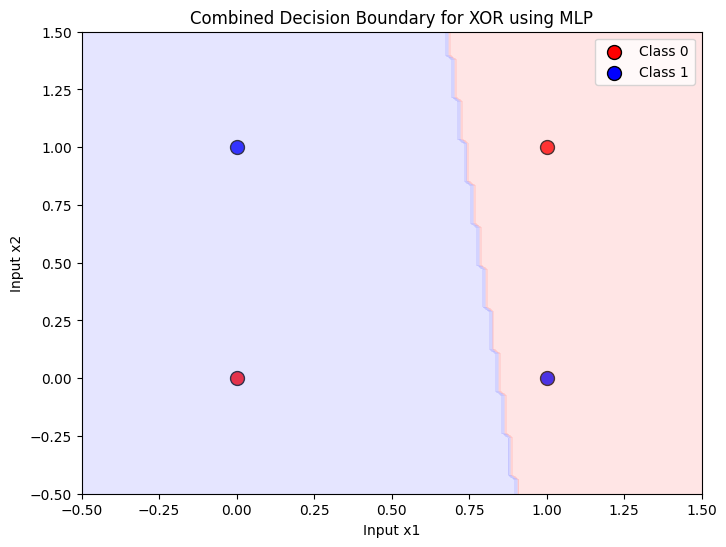

In [853]:
plot_combined_decision_boundary(n.layers[0], xor_points, labels)

#### We have added one more layer with a single neuron now. This single neuron will take the piecewise decision boundaries created by layer 1 as input and will apply linear transformation to that, along with a non linear activation function. Thus, making the combined decision boundary as non-linear.

In [854]:
h = 0.1
for k in range(100):
    
    # Forward pass 
    ypred = [n(input) for input in xor_inputs]

    # Compute loss as a Value instance
    loss = sum([(y - Value(exp))**2 for y, exp in zip(ypred, labels)])
    
    # Zero gradients for each parameter before backward pass
    for p in n.parameters():
        p.grad = 0 

    # Backward pass
    loss.backward()

    # Update the parameters
    for p in n.parameters():
        p.data += -h * p.grad

    # Print loss every 100 iterations
    if k % 100 == 0:
        print(f"Pass: {k} | Loss: {loss.data}")
        plot_combined_decision_boundary(n, xor_points, labels)


TypeError: unsupported operand type(s) for -: 'list' and 'Value'

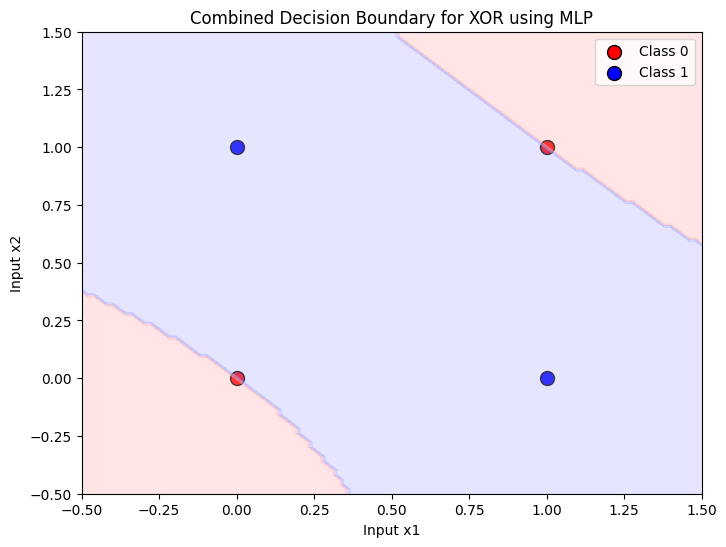

In [825]:
plot_combined_decision_boundary(n, xor_points, labels)